# Data Cleaning - Dealing with Outliers

An important first step in data science is cleaning up your data. This includes identifying and removing data points that may be due to errors in data collection, or other factors that could lead us to make erroneous conclusions about the data. This is *not* the same as "cooking" your data — modifying it specifically to get the results you want. Data cleaning involves a set of methods that are specifically designed to identify and remove data points that are objectively anomalous — that is, you have objective reasons for removing them. Data cleaning steps should always be documented when you write up a study, and should be included in the code you share for analyses so that your procedures are transparent and reproducible. 

## Outlier Identification and Removal

**Outliers** are data points that are "significantly different" from the majority of data points in a data set. "Significantly different" is in quotes here, because this does not necessarily mean we use statistical testing to define outliers, and also that there are several different definitions of "significant" that cam be used to identify outliers.

### Tukey's method
[John Tukey](https://en.wikipedia.org/wiki/John_Tukey), [who was a driving force in the development of exploratory data analysis](https://scholar.google.com/scholar_lookup?&journal=Exploratory+Data+Analysis&author=Tukey+J.+W.&publication_year=1977&volume=Vol.%202), defined outliers as points more than $1.5 x IQR$. Recall that IQR is the *inter-quartile range*, which captures 50% of the data points in a data set. In a box plot (which Tukey invented), the IQR is the "box", and 1.5 IQR are the extent of the "whiskers" in each direction from the median. We noted earlier that in box plots, outliers are represented as individual points in the plot, beyond the whiskers. Since Tukey invented box plots and this definition of outliers, it's not surprising that they are identical. In general, outliers defined in this way will comprise approximately 1% of the data, if the data are approximately normally distributed.

![](images/boxplot_vs_pdf.png)

*Image from [Jhguch](https://en.wikipedia.org/wiki/User:Jhguch) and shared under the  [Creative Commons Attribution-Share Alike 2.5 Generic](https://creativecommons.org/licenses/by-sa/2.5/deed.en) license, via Wikimedia Commons*

### Standard scores

An alternative method is to use standard scores. This is done by applying the ***z* transform** to the data. This transform's formula is:

$$z = {(x - \mu) \over \sigma} $$

Where $x$ is an individual data point, $\mu$ is the mean of the data set, and $\sigma$ is the standard deviation. In other words, the *z* transform takes a data set and transforms it so that its mean is zero (by subtracting the mean from every value), and its standard deviation is 1. 

Put another way, after we apply a *z* transform to a data set, the numerical values in the data set are not in their original units (be that milliseconds, or dollars, or whatever) but in units of standard deviations. So in a *z* transformed data set, a data point with a value of 1 would have had an original value that was 1 standard deviation from the mean. This is where the "standard" in "standard scores" comes from.

Applying a *z* transform is also called *normalizing* the data set, because the *z* transform assumes that the data come from a normal distribution (also known as a Gaussian distribution, or the *bell curve*). The nice thing about standardizing a data set is that the values have fairly straightforward interpretations. In a normal distribution:
- 68.27% of all values fall within ±1 standard deviation of the mean ($1 \sigma$),
- 95.45% of all values fall within ±2 standard deviations of the mean ($2 \sigma$), and
- 99.73% of all values fall within ±3 standard deviations of the mean ($3 \sigma$)

<img alt="M. W. Toews, CC BY 2.5 &lt;https://creativecommons.org/licenses/by/2.5&gt;, via Wikimedia Commons" src="./images/standard_deviation_diagram.svg" width=500>

*Image from M. W. Toews, and shared under the  [Creative Commons Attribution-Share Alike 2.5 Generic](https://creativecommons.org/licenses/by-sa/2.5/deed.en) license, via [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Standard_deviation_diagram_micro.svg)*

This means that if we define outliers as those values *z* > 3 or *z* < -3, then we will tend to reject about 0.25% of a data set. Sometimes, *z* ±2.5 $\sigma$ is used instead. This will tend to reject more data points (typically around 2%). 

## Identifying outliers

First, we'll load in the same Flanker data set we used in the [*Repeated Measures*](./repeated_measures.html) lesson:
~~~python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/flanker_rt_data.csv')
~~~

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/flanker_rt_data.csv')


### Visualizing the distribution

Let's generate a box plot of the entire data set, organized by condition. This is the same as the first box plot in the *Repeated Measures* lesson.

~~~python
sns.catplot(kind='box',
           data=df,
           x='flankers', y='rt')
plt.show()
~~~

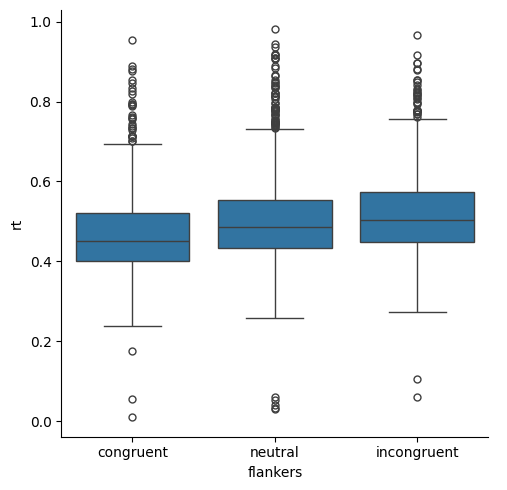

In [2]:
sns.catplot(kind='box',data= df, x='flankers', y='rt')
plt.show()

Let's also look at the distribution of values with a kernel density estimate:

~~~python
sns.displot(kind='kde',
           data=df,
           x='rt', hue='flankers')
plt.show()
~~~

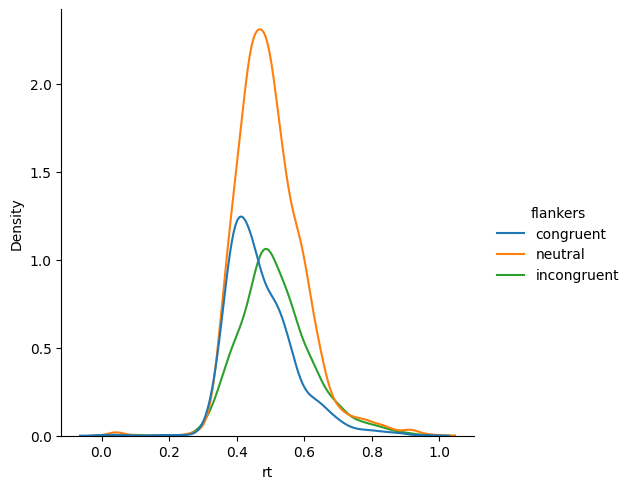

In [3]:
sns.displot(kind = 'kde', data = df, x='rt', hue= 'flankers')
plt.show()

### Idenfity outliers in a DataFrame

To define values based on the IQR, we first need to calculate the IQR. pandas doesn't have a method for this specifically, but we can use the pandas `.quantile()` method with the argument 0.25 to reference the lower end of the IQR (the 0.25 quantile means the point below which 25% of data values lie), and 0.75 for the upper end of the IQR. Since IQR is defined as the range between the 25th and 75th quantiles, we can compute it by subtracting the difference between the two:

~~~python
q1 = df['rt'].quantile(0.25)
q3 = df['rt'].quantile(0.75)
iqr = q3 - q1
~~~



In [4]:
q1 = df['rt'].quantile(0.25)
q3 = df['rt'].quantile(0.75)
iqr = q3 - q1


The variable `iqr` represents the size of the box in the box plot of the data. Recall that our definition of outliers is 1.5 x IQR — the length of the whiskers in the box plot. 

We can now define the threshold for values we well call "outliers" (i.e., the length of the whiskers) based on `iqr`:

~~~python
out_low = q1 - 1.5 * iqr
out_high = q3 + 1.5 * iqr
~~~

In [5]:
out_low = q1 - 1.5 * iqr
out_high = q3 + 1.5 * iqr

So `out_low` (the end of the bottom whisker) is 1.5 x IQR below q1 (the lower end of the box), and likewise for `out_high`. 

Recall from the [pandas](../3-python/pandas-dataframes.html) lesson that we can select values in a DataFrame using a Boolean mask. We can do that here to identify the rows of the DataFrame where the RT values are lower than 1.5 x IQR:

~~~python
df.loc[:, 'rt'] < out_low
~~~

In [6]:
df.loc[:, 'rt'] < out_low

0       False
1       False
2       False
3       False
4       False
        ...  
4284    False
4285    False
4286    False
4287    False
4288    False
Name: rt, Length: 4289, dtype: bool

The result will have values of `True` for those data points that are "low" outliers, and `False` for all other data points. We can count the number of these by passing the mask to `np.sum()` (since `True` = `1` and `False` = `0`)

~~~python
np.sum(df.loc[:, 'rt'] < out_low)
~~~

In [7]:
np.sum(df.loc[:, 'rt'] < out_low)


np.int64(10)

We can do the same to identify outliers at the high end of the range of values, using the `>` operator this time:

~~~python
np.sum(df.loc[:, 'rt'] > out_high)
~~~

In [8]:
np.sum(df.loc[:, 'rt'] < out_high)

np.int64(4179)

Consistent with what we saw in the box plot, there are more outliers at the high (slow RT) end of the distribution than at the low (fast RT) end. 

#### Marking data points as outliers

We'll worry about what to do with outliers later — after we've described standard scores. For now, let's make a column in `df` called `outliers_tukey` that is a Boolean mask: values of `True` in rows with outlier RT values, and `False` for all other rows. 

To do this, we want to combine the two masking operations above `< out_low` and `> out_high`. We can do that using the OR `|` operator, as long as we include each of our masking operations in parentheses (this last bit is important, but easy to forget!):

~~~python

(df.loc[:, 'rt'] < out_low) | (df.loc[:, 'rt'] > out_high)
~~~

In [9]:
(df.loc[:, 'rt'] > out_high) | (df.loc[:, 'rt'] < out_low)

0       False
1       False
2       False
3       False
4       False
        ...  
4284    False
4285    False
4286    False
4287    False
4288     True
Name: rt, Length: 4289, dtype: bool

It's a bit hard to confirm that this works from the output above, but if we pass that whole expression to `np.sum()` we can see that the number of all `True` values is the same as the total of the `out_low` and `out_high` values reported above:

~~~python
np.sum((df.loc[:, 'rt'] < out_low) | (df.loc[:, 'rt'] > out_high))
~~~

In [11]:
np.sum((df.loc[:, 'rt'] < out_low) | (df.loc[:, 'rt'] < out_high))

np.int64(4179)

To actually use this expression to create a new column, we just have to assign the result to a new column name in `df`:

~~~python
df['outliers_tukey'] = (df.loc[:, 'rt'] < out_low) | (df.loc[:, 'rt'] > out_high)
df.head()
~~~

In [12]:
df['outliers_tukey']= (df.loc[:, 'rt'] < out_low) | (df.loc[:, 'rt'] < out_high)
df.head()

,participant,block,trial,flankers,rt,outliers_tukey
0,s25,1,1,congruent,0.652072,True
1,s25,1,2,neutral,0.644872,True
2,s25,1,3,congruent,0.445182,True
3,s25,1,4,neutral,0.525200,True
4,s25,1,5,congruent,0.533328,True


And double-check the number, using the pandas `.sum()` method:

~~~python
df['outliers_tukey'].sum()
~~~

In [13]:
df['outliers_tukey'].sum()

np.int64(4179)

### Standard scores (*z* transform)

We can convert scores to standard scores very easily, using the `zscore()` function in `scipy.stats`:

~~~python
from scipy import stats

df['rt_z'] = stats.zscore(df['rt'])
df.head()
~~~

In [14]:
from scipy import stats

df['rt_z'] = stats.zscore(df['rt'])
df.head()

,participant,block,trial,flankers,rt,outliers_tukey,rt_z
0,s25,1,1,congruent,0.652072,True,1.526800
1,s25,1,2,neutral,0.644872,True,1.456483
2,s25,1,3,congruent,0.445182,True,-0.493736
3,s25,1,4,neutral,0.525200,True,0.287737
4,s25,1,5,congruent,0.533328,True,0.367119


Now we can identify outliers as those rows where `rt_z > 2.5` or `rt_z < -2.5`. We'll define a variable `z_thresh` because that way we can later change it to a different value (like 3) if we desire.
~~~python
z_thresh = 2.5
(df['rt_z'] > z_thresh) | (df['rt_z'] < z_thresh)

~~~

In [16]:
z_thresh = 2.5
(df['rt_z'] > z_thresh) | (df['rt_z'] < -z_thresh)


0       False
1       False
2       False
3       False
4       False
        ...  
4284    False
4285    False
4286    False
4287    False
4288     True
Name: rt_z, Length: 4289, dtype: bool

More simply, we can take the absolute value of *z* (which ignores the `-` sign):
~~~python
np.abs(df['rt_z']) > z_thresh
~~~

In [17]:
np.abs(df['rt_z']) > z_thresh

0       False
1       False
2       False
3       False
4       False
        ...  
4284    False
4285    False
4286    False
4287    False
4288     True
Name: rt_z, Length: 4289, dtype: bool

The number of outliers identified this way is:

~~~python
np.sum(np.abs(df['rt_z']) > z_thresh)

~~~

You'll note that there are actually fewer outliers defined this way as using the 1.5 x IQR (Tukey) method. Why is this? As noted earlier, Tukey's threshold and *z* > 2.5 are only approximately the same, so we expect minor differences. However, we noted that the 1.5 x IQR range is a bit *wider* than *z* > 2.5, meaning it should capture more data points and *fewer* values should be identified as outliers by Tukey's method. Yet here, more are. The reason for this is that both Tukey's and the standard score methods assume our data are normally distributed, when in fact they are skewed, with more values at the high (slow RT) end than at the low (fast RT) end. Since the data don't fit the assumptions of the methods we used, we get unexpected results. 

#### Write column of standard score outliers
We'll worry about skewness a little later, but for now we will add a column marking outliers as defined this way, similarly to what we did above for the Tukey method:

~~~python
df['outliers_z'] = np.abs(df['rt_z']) > 3
df.head()
~~~

In [18]:
df['outliers_z'] = np.abs(df['rt_z']) > 3
df.head()

,participant,block,trial,flankers,rt,outliers_tukey,rt_z,outliers_z
0,s25,1,1,congruent,0.652072,True,1.526800,False
1,s25,1,2,neutral,0.644872,True,1.456483,False
2,s25,1,3,congruent,0.445182,True,-0.493736,False
3,s25,1,4,neutral,0.525200,True,0.287737,False
4,s25,1,5,congruent,0.533328,True,0.367119,False


---
## Why are outliers a problem?

Outliers are a problem because they have disproportionate *leverage* on statistical properties of the data, such as the mean and variance. We can see this by creating a small, simulated data set from a normal distribution, then replacing one value with either an extremely different or just slightly different data point. Let's do this, and compare the means and standard deviations in each case. We use NumPy's `np.random.default_rng().normal()` function to do this:

~~~python
# Create array with mean=0, standard deviation=1, and 10 data values
data = np.random.default_rng().normal(0, 1, 10)

print("Data:", str(data))
print("Mean of data with no outliers:", str(round(np.mean(data), 5)))
print("Standard deviation of data with no outliers:", str(round(np.std(data), 5)))
~~~

~~~python
data_not_extreme = np.copy(data)
# replace last value in array with outlier
data_not_extreme[-1] = 3

print("Data:", str(data_not_extreme))
print("Mean of data with minor outlier:", str(round(np.mean(data_not_extreme), 5)))
print("Standard deviation of data with minor outlier:", str(round(np.std(data_not_extreme), 5)))
~~~

~~~python
data_extreme = np.copy(data)
# replace last value in array with outlier
data_extreme[-1] = 10

print("Data:", str(data_extreme))
print("Mean of data with extreme outlier:", str(round(np.mean(data_extreme), 5)))
print("Standard deviation of data with extreme outlier:", str(round(np.std(data_extreme), 5)))
~~~

From the above we can see that a larger outlier has a larger impact on both the mean and variance of the data. Also remember, when looking at the information above, that the true population mean of the data (as specified in the arguments to the random number generator) is 0 and the true standard deviation is 1. Using this normal distribution makes it easy to see that outliers bias our statistics away from the true population mean and variance. 

The impact of outliers is often less extreme — in the above examples, our data set comprised only 10 values, and so making one an outlier meant that 10% of data points were outliers — whereas by the definitions above, we would normally expect only 1–2% of data points to be outliers. 

If we re-run the simulations with a data set of 100 values and one outlier, you can see that the impact of even an extreme outlier is much reduced:

~~~python
# Create array with mean=0, standard deviation=1, and 10 data values
data = np.random.default_rng().normal(0, 1, 100)

print("Data:", str(data))
print("Mean of data with no outliers:", str(round(np.mean(data), 5)))
print("Standard deviation of data with no outliers:", str(round(np.std(data), 5)))
~~~

~~~python
data_extreme = np.copy(data)
# replace last value in array with outlier
data_extreme[-1] = 10

print("Data:", str(data_extreme))
print("Mean of data with extreme outlier:", str(round(np.mean(data_extreme), 5)))
print("Standard deviation of data with extreme outlier:", str(round(np.std(data_extreme), 5)))
~~~

The impact of an individual outlier is thus dependent on the size of the data set, and indeed in many data sets comprising a large number of data points, the impact of one outlier (or even 1% of the data values being outliers) can be quite minimal. 

However, the impact of an outlier is also proportionate to its size, relative to the other values in the data set. Here we use 100 as the anomalous value, rather than 10, again in a data set with 100 values:

~~~python
data_extreme = np.copy(data)
# replace last value in array with outlier
data_extreme[-1] = 100

print("Data:", str(data_extreme))
print("Mean of data with extreme outlier:", str(round(np.mean(data_extreme), 5)))
print("Standard deviation of data with extreme outlier:", str(round(np.std(data_extreme), 5)))
~~~

Now the impact of this 1% of the data is much more extreme. In some data sets, it is unlikely or even impossible to have very extreme outliers. For example, in the Flanker study we're working with, the lower bound of RT is 0, and the upper bound is 1000 ms, because if a participant didn't make a response iwthin 1 s of the stimulus, the trial automatically ended without recording a response. However, in some data sets more extreme values are possible. For example, a technical problem with a neuroimaging system, such as EEG or single-unit recording electrodes, could result in very extreme values relative to normal physiologically-plausible values. 

## Which method to use?

If you look at the image idescribing the Tukey method above, you can see that the range of the distribution covered by $1.5 x IQR$ is just slightly larger than 2.5 $\sigma$. So, the Tukey method is roughly equivalent to using a *z* threshold of ±2.5. The $1.5 x IQR$ range is slightly wider than *z* = 2.5, and so may on average identify slightly fewer data points as outliers, but the result is probably negligible in practice. However, many researchers use *z* > 3 as their threshold for outliers, which will tend to identify fewer outliers than the Tukey method.

Since box plots are a great — and well-known — way of visualizing data distributions, there is a logic to using the $1.5 x IQR$ method to identify outliers since the results will be consistent. However, the approximate equivalence between the Tukey method and *z* = 2.5 is *only true if the data are normally distributed*. For skewed data, like RT data, this method may exclude too many outliers. In particular, it will tend to exclude more long RT values than short RT values, even though many of the long RT values are likely valid (especially in a case like the present experiment, where trials were cut off at 1 s, preventing really long RTs).

### An empirical study addressing outlier removal with RT data

Berger and Kiefer ([2021](https://doi.org/10.3389/fpsyg.2021.675558)) performed a study in which they simulated many samples of reaction times, and introduced either more- or less-extreme outliers into the data. Essentially this was a more sophisticated version of the simulations shown above, and using the natural properties of RT data, and simulating an experiment with different conditions. Berger and Kiefer compared Tukey's method, the *z* transform method using thresholds of both 2 and 3, and several other methods, as well as simply leaving outliers in the data. Since this was simulated data, the authors knew the true values of the mean and standard deviation in each data set, which allowed them to compare each method to the "truth" — something we never have the luxury of knowing in experimental psychology and neuroscience. 

Berger and Kiefer found that the *z* transform method was the best choice. With RT data, as noted above, Tukey's method excluded too many data points on the long-RT side of the distribution. This had two negative impacts: firstly, it made the data appear more normally distributed than it really was, and secondly, it biased the statistical analyses towards false positives (Type 1 errors) — finding statistically significant differences between conditions when they were not present in the "true" data. Berger and Kiefer also observed that *not* rejecting outliers was the worst choice. The outliers led to a high rate of false negative results (Type 2 errors), meaning that true differences between conditions were not found to be statistically significant, due to the presence of outliers. 

The *z* transform was not perfect (and we cannot expect any method to be), but it was more balanced in not rejecting disproportionately more long RTs than short RTs, rejecting fewer data points overall, and biasing the statistical analyses the least. Since in general, with experimental data we want to only exclude truly anomalous data points, I suggest using a *z* threshold of 3 for outlier removal. Using a threshold of 2 or 2.5 will naturally exclude more data points, increasing the likelihood that valid data is excluded.

It's also important to note that trying different outlier removal methods on a real data set, or even different *z* thresholds to define outliers, introduces a component of *researcher bias* (or *researcher degrees of freedom*) into the analysis. Once you start doing this, it becomes easy to choose a method based on what "looks right" — which is, ultimately, what the researcher *thinks* the data should look like, not the true nature of the data. For this reason, parameters such as outlier definition method and threshold should be chosen prior to performing the analyses (ideally, [preregistering](../1/preregistration.html) the plan even before running the experiment).
It's also important to note that trying different outlier removal methods on a real data set, or even different *z* thresholds to define outliers, introduces a component of *researcher bias* (or *researcher degrees of freedom*) into the analysis. Once you start doing this, it because easy to choose a method based on what "looks right" — which is, ultimately, what the researcher *thinks* the data should look like, not the true nature of the data. For this reason, parameters such as outlier definition method and threshold should be chosen prior to performing the analyses (ideally, [preregistering](../1-intro/preregistration.html) the plan even before running the experiment).



---
## What to do with outliers

We have three basic options for outliers:
1. Ignore them — just include them in the data and all analyses
2. Remove them completely from the DataFrame
3. Replace them with non-outlier values

### 1. Ignore them

Some scientists fundamentally do not believe in rejecting outliers. In working with data from human or animal participants, one can argue that any behavioural response is possibly valid, and outliers may represent interesting data points for any number of reasons (e.g., an exceptionally slow RT may mean the person spent a lot of time thinking about the stimulus and trying to decide on a response). 

Another reason to consider not removing outliers (or using some other definition of outliers) is if the data are not actually normally distributed. Indeed, the RT data we have been working with are not normally distributed, they are skewed - an issue which we will address below. Skew is a relatively minor violation of normality. More generally, although the normal distribution is very common in nature, not all data is normally distributed, and so it is worth examining the distribution of your data (one reason we spend so much time looking at box plots, histograms, and other visualizations of distributions).

On the other hand, outliers can arise for reasons that really aren't of experimental interest ([McCormack & Wright, 1964)](https://doi.org/10.1037/h0083285). For instance, in the present data set we have a few very short RTs from true measurement error. In the box plot of the data, we can see 2–3 data points in each flanker condition below 100–200 ms. It is nearly impossible for a typical human to respond to a stimulus in less than this amount of time, particularly when some decision (like which way an arrow is pointing) is required first ([Luce, 1991](https://dx.doi.org/10.1093/acprof:oso/9780195070019.001.0001); [Whelan, 2008](https://dx.doi.org/10.1007/BF03395630)). So rather than being scientifically interesting, these outliers probably reflect trials when the participant accidentally pressed a response button. Likewise, exceptionally long RTs could reflect trials on which the participant thought they pressed the button then realized they didn't, trials where the participant got distracted, or sneezed and didn't see the stimulus, etc.. As noted above, Berger and Kiefer (2021) found that not rejecting outliers decreased the likelihood of finding statistically significant differences, when those differences were actually present in the data.

My general advice is not to ignore outliers, unless you have strong, principled reasons as to why outliers might be interesting (or not actually outliers, if the distribution is not normal) and how you would interpret them.

### 2. Remove them from the data set

Removing data points — known as **trimming** or **truncation** — is acceptable in some cases, but problematic in others. For repeated measures data, it's often fine to remove outliers at the individual participant level, since we have many other samples of the measurement (i.e., the repeated measures, such as trials). On the other hand, if we only have one measurement for a particular "unit" of the experimental design (e.g., one measurement from each participant, in each condition), then we might not want to completely lose that data point. This is especially true for data that will be analyzed statistically with a *t* test or ANOVA, because these methods cannot handle missing values. 

### 3. Replace them with non-outlier values

Another approach to dealing with outliers is to replace them with a less-outlying value. This could be the mean value, or the most extreme value that is not considered an outlier. Replacing an outlier with the mean value basically "neutralizes" that data point, since it is equivalent to the mean it doesn't alter the mean  of the data points. However, it does artificially reduce the variance in the data a bit, because variance is, by definition, the amount by which any data point differs from the mean. But if you are only replacing 1–2% of your data values, the impact on variance should be fairly small. Also note that, properly, the mean that is used as the replacement value should be computed only from all of the *non-outlier* data values. This is because a major reason to replace or remove outliers in the first place is that they have disproportionate influence on the mean. 

Replacing the outlier with the most-extreme non-outlier value will preserve variance contributed by that data point, but reduce the variance relative to retaining the outlier value. Likewise, the impact on the mean will not be neutral, but it will be rather small. Note that an assumption of replacing the outlier value with another, relatively extreme (relative to the mean), value is that the outlier was actually a valid measurement, perhaps with some noise in it. Since we don't know for sure what the true value of the data was, in principle it seems better to replace outliers with the mean. 

## Replacing outliers with mean values

Based on the information above, we will approach outliers in the Flanker data set by applying a *z* transform, defining outliers as those values with $\lvert z \lvert \gt 3$, and replace these values with the mean (where the mean is calculated excluding the outlier values).

First, as we did above, we'll define `z_thresh` as 3 and fill the `outliers_z` column with `True` where $\lvert z \lvert \gt 3$ and `False` for all other rows. 
~~~python
z_thresh = 3
df['outliers_z'] = np.abs(df['rt_z']) > z_thresh
~~~

Next we'll create a column containing the mean RT. To exclude the outlier values in computing this, we select only the rows where `outliers_z` is False:

~~~python
df['rt_mean'] = df[df['outliers_z'] == False]['rt'].mean()
df.head()
~~~

Finally, we fill a new column, `rt_clean`, with either the original RT value (for non-outliers), or the mean RT (for outliers). The way that we create a new pandas column, contingent on the values of another column, is using the `np.where()` function. This is essentially a way of running an `if-else` conditional statement on each row in a pandas column. `np.where()` takes three arguments, which are (in order), the conditional statement, the value to fill in the new column if the conditional is true, and finally the value to fill in if the conditional is false. 

So the code below tests, for each row, whether `outliers_z` is `True`. If it is (i.e., an outlier), the mean RT is filled in; otherwise the original RT value for that trial is copied to the `clean_rt` column. The three arguments to `np.where()` are each shown on their own line, to make it a little more readable:

~~~python
df['rt_clean'] = np.where(df['outliers_z'] == True, 
                          df['rt_mean'], 
                          df['rt'])
df.head()
~~~

Although the first few rows in this DataFrame were not identified as outliers, we can confirm that this procedure worked by filtering the DataFrame to only show us rows where `outliers_z` is `True`:

~~~python
df[df['outliers_z'] == True]
~~~

### Reporting outlier rejections

In any report describing your data, you should state:
- the method you used to identify outliers
- how you dealt with outliers
- what proportion of the data were identified as outliers, and thus treated

To get this last value, we can simply compute the number of `True` values in `outliers_z`, divided by the total number of trials (rows):

~~~python
outliers_removed = df['outliers_z'].sum() / df['outliers_z'].count()

# Convert proportion to percent, and round to 2 decimal places
print(str(round(outliers_removed * 100, 2)), "% of the data identified as outliers and replaced with mean value.")

~~~

---
## Working with nested data

All of the above was correct, for data without nesting or repeated measures. The reason for this caveat is that with nested data, what constitutes an "outlier" for one source of data (e.g., one participant) may be a very reasonable value for another person. This is perhaps most intuitive if we think about an experiment comparing older and younger adults. With age, RTs on average get longer. So slow RT that is an outlier for an 18 year old university student may be about the average RT for someone who is 80 years old. 

To properly address the nested structure of data in identifying and correcting outliers, we can use the same steps as above, but using the split-apply-combine approach provided by pandas `.groupby()` method. In other words, we split the data by participant, apply the outlier detection and correction steps, and then combine the data into a new column in the DataFrame.

<div class="alert alert-block alert-info">
    
The code below is probably the most complex that we've worked with so far. Take your time going through this, and try to understand it as fully as you can. It may seem like a convoluted series of steps, but they are a logical sequence and each one is optimized for pandas. This is in fact [pandas' suggested approach for outlier correction](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation)

</div>

Since we've added lots of columns above, let's start fresh by re-loading the DataFrame from the file:

~~~python
df = pd.read_csv('data/flanker_rt_data.csv')
~~~

### Compute *z* scores by participant
Now let's split by participant and apply the *z* transform to the split data. Pandas has a useful method, `.transform()`, that allows us to run a non-pandas function on a selection from a DataFrame. So we group by participant, select only the `rt` column to operate on, and then `.transform(stats.zscore)` and assign this to a new column in the DataFrame, `rt_z`. Note that when we pass a function to `.apply()`, we *do not* put parentheses after the name of the function we are using. That is, if we were running `stats.zscore` on its own (see above), we would use `stats.zscore(df['rt'])`. But since we have already selected the data that we are passing with `.transform()`, we don't use the parentheses with the function call. 

~~~python
df['rt_z'] = df.groupby('participant')['rt'].transform(stats.zscore)
df.sample(12)
~~~

### Compute mean RT from valid trials for each participant
Likewise, we need to compute the mean RT within participants, so again we could split by participant and then compute the within-participant mean, this time passing `np.mean` to `.transform()`:

~~~python
df['rt_mean'] = df.groupby('participant')['rt'].transform(np.mean)
~~~

But actually, doing the above computes the mean across all trials for each participant — including the outlier trials. We can compute the mean across only the non-outlier trials by adding a filter  on `df` prior to the `groupby` operation:

~~~python
df['rt_mean'] = df[np.abs(df['rt_z']) <= z_thresh].groupby('participant')['rt'].transform(np.mean)
df.head()
~~~

### Fill in mean values for outlier rows
There's a catch with this however — since we grouped *filtered* `np.abs(df['rt_z']) <= z_thresh` data, this only fills in the *non-outlier* rows with mean RT, because those are the only rows that get passed to the `.transform()` method. The `mean_RT` rows where *z* exceeds outlier threshold are filled with `NaN`, since pandas doesn't know what else to do with them. We can see this if we ask for a sample of just the rows that exceed the outlier threshold:

~~~python
# view sample of rows to confirm RT varies by participant
df[df['rt_z'] > z_thresh].sample(10)
~~~

To fix this, we need to group the data by participant again, except this time not excluding outlier rows. Then, we need to replace all NaNs in the `rt_mean` column with the mean RT for that participant.

To do this, we run another `.groupby()` + `.transform()` operation, but this time applying a more complex transformation using a [**lambda function**](https://www.datacamp.com/community/tutorials/python-lambda). Lambda functions are basically a way of writing a small Python function inside a command. They are used when what you need to do is a bit more complex or specific than can be done with an existing method or function.  

In this case, what we want to do is group `df` by participant ID, then fill in the NaN values with the mean RT from all non-NaN values for that participant. We do this by applying two operations in sequence: first we use `np.nanmean()` to compute the mean over all non-NaN RT values for that participant, and then we pass that value to `.fillna()` to replace any NaN values for that participant with the mean RT. This works because the `x` in the lambda function is a variable that refers to the entire grouped data set that we pass to it:

~~~python
df['rt_mean'] = df.groupby('participant')['rt_mean'].transform(lambda x: x.fillna(np.nanmean(x)))

# Check by again printing a sample of outlier rows
df[df['rt_z'] > z_thresh].sample(10)
~~~

<div class="alert alert-block alert-info">
    
If you don't fully understand the lambda function above, that's OK. It is fairly advanced relative to most of what we've covered so far. However, it's introduced here because it is the proper and efficient way to replace outlier values. It's also worth knowing about lambda functions because you will start seeing them more in the future! 

</div>

### Create final output column
Next, we want to create a column called `rt_clean` that contains the original RT for non-outlier trials, and the mean RT for that participant for outlier trials. We can use `np.where()` to find outliers and replace them with each individual's mean RT. Below, we do this in one line of code, which is more compact and efficient than we did above. Earlier, we first created a column, `outliers_z` and then used that to determine which rows would be filled with the original RT versus the mean RT. However, creating a column in our DataFrame that we will never use again is not efficient use of resources. Here we simply use the threshold test as our conditional. 

~~~python
df['rt_clean'] = np.where(np.abs(df['rt_z']) > z_thresh, 
                          df['rt_mean'], 
                          df['rt'])

df.sample(10)
~~~

Since a random sample of 10 rows may not show any where *z* actually exceeded our outlier threshold, we can use filtering to view only those rows where the absolute value of *z* was greater than our threshold, to confirm that in those rows `rt_clean` is the same as `rt_mean`:

~~~python
df[np.abs(df['rt_z']) > z_thresh].sample(10)
~~~

Finally we'll print out the proportion of data identified as outliers, by computing the number of *z* values that exceed our threshold, relative to the total number of *z* values (i.e., the number of rows in the DataFrame):

~~~python
outliers = df[df['rt_z'] > z_thresh]['rt_z'].count() / df['rt_z'].count()

# Convert proportion to percent, and round to 2 decimal places
print(str(round(outliers * 100, 2)), "% of the data identified as outliers and replaced with mean value.")
~~~

## Visualizing the cleaned data

### Box plots
#### Before outlier correction
Let's generate a box plot of the original RT values for reference (this is the same as the one plotted at the top of this lesson).

~~~python
sns.catplot(kind='box',
           data=df,
           x='flankers', y='rt')
plt.show()

~~~

#### After outlier correction

Below, we can see that the number of short RT outliers is reduced, and those that remain are very close to the whiskers (and also greater than 200 ms). At the same time, the number of outliers at the long RT end of the distribution is also reduced, but there are still more of them than at the short end (which is reasonable, for RT data).

~~~python
sns.catplot(kind='box',
           data=df,
           x='flankers', y='rt_clean')
plt.show()
~~~

### Kernel density estimates

#### Before outlier correction

~~~python
sns.displot(kind='kde',
           data=df,
           x='rt', hue='flankers')
plt.show()
~~~

#### After outlier correction

We can see that the distributions look less "peaky" in the middle with long tails. The long tails were caused by the few outlier data points at extreme ends of the 0–1 s range.

~~~python
sns.displot(kind='kde',
           data=df,
           x='rt_clean', hue='flankers')
plt.show()
~~~